In [49]:
import pandas as pd
from itertools import product
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [48]:

df = pd.read_csv('dataset_forcasting.csv')
df = df.dropna()
df = df.drop_duplicates()

In [13]:
summary = df.describe()
summary
# Je ne pense pas qu'il y a des donnees abberantes car la valeur maximale d'emmision CO2 correspont a China, et la plus petite correspons a "Saint Helena, Ascension and Tristan da Cunha"


,Unnamed: 0,Year,Energy
count,49335.000000,49335.000000,4.933500e+04
mean,24879.741036,1993.550035,2.427925e+01
std,14361.476221,13.851943,1.330747e+02
min,1.000000,1970.000000,2.045000e-07
25%,12431.500000,1982.000000,8.681371e-02
50%,24874.000000,1994.000000,9.304204e-01
75%,37320.500000,2006.000000,8.183553e+00
max,49728.000000,2017.000000,4.433866e+03


In [14]:
df.drop('Unnamed: 0', axis = 1,inplace = True)

In [15]:
def plot_emission_country(country_name: str): 
    country = df[df["Country"] == country_name].set_index("Year").groupby("Sector")
    country["Energy"].plot(kind='line', figsize=(12,8), title="CO2 Emissions by Sector in " + country_name)
    plt.xlabel("Year")
    plt.ylabel("Energy (kg of CO2 per capita)")
    plt.show()

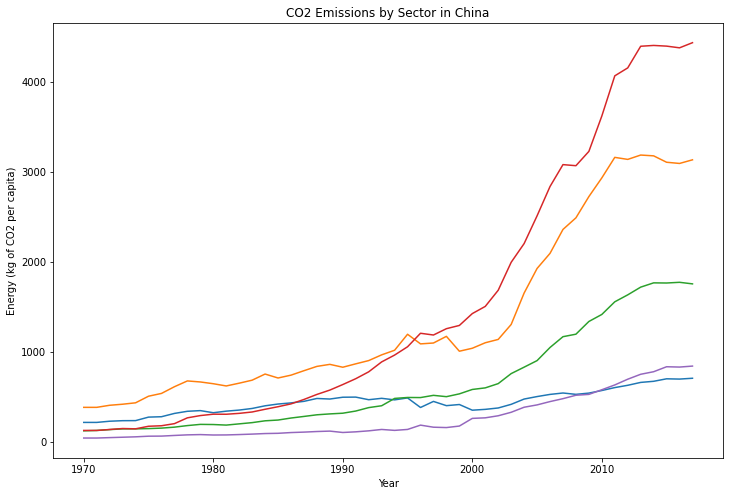

In [16]:
plot_emission_country("China")

In [17]:
import numpy as np

def detect_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    outliers = group[(group < lower_bound) | (group > upper_bound)]
    return outliers

df_by_country = df.set_index("Year").groupby("Sector")
outliers = df_by_country['Energy'].apply(detect_outliers).dropna()
print("Outlier indices:", outliers)

Outlier indices: Sector     Year
Buildings  2007     13.599250
           2008     13.571973
           2009     17.401751
           2010     16.803222
           2011     18.567001
                      ...    
Transport  2013    611.213371
           2014    628.002813
           2015    657.324001
           2016    668.394870
           2017    677.247811
Name: Energy, Length: 7566, dtype: float64


In [18]:
def delete_outliers(df):
    outliers = detect_outliers(df['Energy'])
    df = df[~df['Energy'].isin(outliers)]
    return df

# delete_outliers(df_by_country)

In [19]:
import scipy.stats as stats

def check_normality_grouped(grouped_data):
    for name, group in grouped_data:
        stat, p = stats.normaltest(group['Energy'])
        if p < 0.05:
            print(f'{name} does not follow a normal distribution (p = {p:.3f})')
        else:
            print(f'{name} follows a normal distribution (p = {p:.3f})')


In [20]:
grouped_data =  df[df["Country"] == "China"].set_index("Year").groupby("Sector")
check_normality_grouped(grouped_data)


Buildings follows a normal distribution (p = 0.605)
Other industrial combustion does not follow a normal distribution (p = 0.017)
Other sectors does not follow a normal distribution (p = 0.019)
Power Industry does not follow a normal distribution (p = 0.022)
Transport does not follow a normal distribution (p = 0.010)


In [21]:
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.seasonal import seasonal_decompose

def is_stationary_grouped(data):
    results = {}
    for sector, sector_data in data:
        result = ts.adfuller(sector_data["Energy"])
        results[sector] = result[0] < result[4]['5%']
    return results

country = df[df["Country"] == "China"].set_index("Year").groupby("Sector")
print(is_stationary_grouped(country))


{'Buildings': False, 'Other industrial combustion': False, 'Other sectors': False, 'Power Industry': False, 'Transport': False}


In [22]:
df_yearly_sum = df.groupby("Year").sum()
df_yearly_sum

,Energy
Year,
1970,15803.562217
1971,15716.382885
1972,16498.549902
1973,17467.711236
1974,17403.935803
1975,17325.737497
1976,18319.164659
1977,18867.993753
1978,19565.331197


In [23]:
from statsmodels.tsa.stattools import adfuller, kpss


def test_stationarity(df, **kwargs):
    ## ADFuller
    adf_result = adfuller(df, **kwargs)

    if adf_result[1] < 0.05: adf_decision = 'Stationary'
    else : adf_decision = 'Non-Stationary'

    adf_dict = {'decision': adf_decision,
                'Test Statistic': adf_result[0],
                'p-value': adf_result[1],
                'Numbers of lags': adf_result[2]}
    
    for key, value in adf_result[4].items():
        adf_dict[f"Critical Value {key}"] = value
    
    ## KPSS
    kpss_result = kpss(df, **kwargs)
    
    if kpss_result[1] > 0.05: kpss_decision = 'Stationary'
    else : kpss_decision = 'Non-Stationary'

    kpss_dict = {'Decision': kpss_decision,
                 'Test Statistic': kpss_result[0],
                 'p-value': kpss_result[1],
                 'Numbers of lags': kpss_result[2]}

    for key, value in kpss_result[3].items():
        if key != "2.5%" :
            kpss_dict[f"Critical Value {key}"] = value

    df = pd.DataFrame(adf_dict.values(), columns=['ADF'], index=adf_dict.keys())
    df['KPSS'] = kpss_dict.values()
    return df

In [24]:
test_stationarity(df_yearly_sum)

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


,ADF,KPSS
decision,Non-Stationary,Non-Stationary
Test Statistic,0.944017,0.545594
p-value,0.993639,0.031398
Numbers of lags,4,10
Critical Value 1%,-3.592504,0.347
Critical Value 5%,-2.93155,0.463
Critical Value 10%,-2.604066,0.739


In [25]:
df_diff = df_yearly_sum.diff(1).diff(1).dropna()
test_stationarity(df_diff)

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1875: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)
/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,ADF,KPSS
decision,Stationary,Stationary
Test Statistic,-9.340663,0.149169
p-value,0.0,0.1
Numbers of lags,1,10
Critical Value 1%,-3.588573,0.347
Critical Value 5%,-2.929886,0.463
Critical Value 10%,-2.603185,0.739


In [107]:
step = int(0.8*len(df_yearly_sum))
X_train, X_test = df_yearly_sum[:step], df_yearly_sum[step:]
X_train

,Energy
Year,
1970,15803.562217
1971,15716.382885
1972,16498.549902
1973,17467.711236
1974,17403.935803
1975,17325.737497
1976,18319.164659
1977,18867.993753
1978,19565.331197


In [108]:
from itertools import product
import warnings

def find_best_arima(data, max_p, max_q, max_d):
    best_params = {'p': None, 'd': None, 'q': None, 'rmse': float('inf')}
    comb = product(*[range(max_p+1), range(max_d+1), range(max_q+1)])
    aicc = np.inf
    for (p,d,q) in comb:
        if p == q == 0 : continue
        arima = ARIMA(data,
                      order=(p,d,q))  
        fit2 = arima.fit()
        if aicc > fit2.aicc :
            aicc = fit2.aicc
            best_model = arima
            best_fit = fit2
            best_params = {'p': p, 'd': d, 'q': q}
    print(best_params)
    return best_model, best_fit

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model, fitted= find_best_arima(X_train, 2,3,3)
    
fitted.summary()

{'p': 0, 'd': 3, 'q': 3}


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 Energy   No. Observations:                   38
Model:                 ARIMA(0, 3, 3)   Log Likelihood                -257.182
Date:                Thu, 02 Feb 2023   AIC                            522.363
Time:                        11:18:31   BIC                            528.585
Sample:                             0   HQIC                           524.511
                                 - 38                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0778      0.198     -5.443      0.000      -1.466      -0.690
ma.L2         -0.3477      0.195     -1.787      0.074      -0.729       0.034
ma.L3          0.4957      0.140      3.548      0.000       0.222       0.770
sigma2      1.024e+05    3.3e+04      3.104      0.002    3.77e+04    1.67e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 2.51
Prob(Q):                              0.85   Prob(JB):                         0.28
Heteroskedasticity (H):               0.45   Skew:                             0.64
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


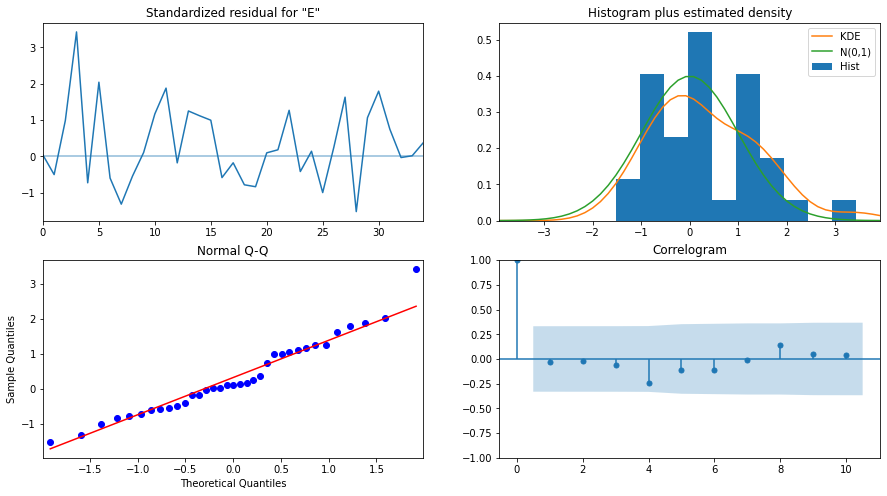

In [109]:
g = fitted.plot_diagnostics(figsize=(15,8))
plt.show()

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


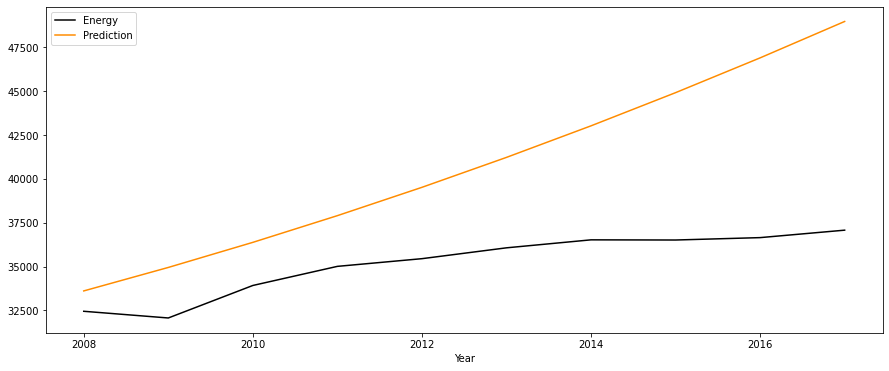

In [110]:
# Predictions
y_pred = fitted.forecast(len(X_test))
rmse = np.sqrt(mean_squared_error(X_test, y_pred))
y_pred.index = X_test.index

def plot(X_test, y_pred):
    fig, ax = plt.subplots(figsize=(15,6))
    X_test.plot(ax=ax, color='black', label='Data')
    y_pred.plot(ax=ax, color='darkorange', label='Prediction')
    plt.legend()
    plt.show()
plot(X_test, y_pred)

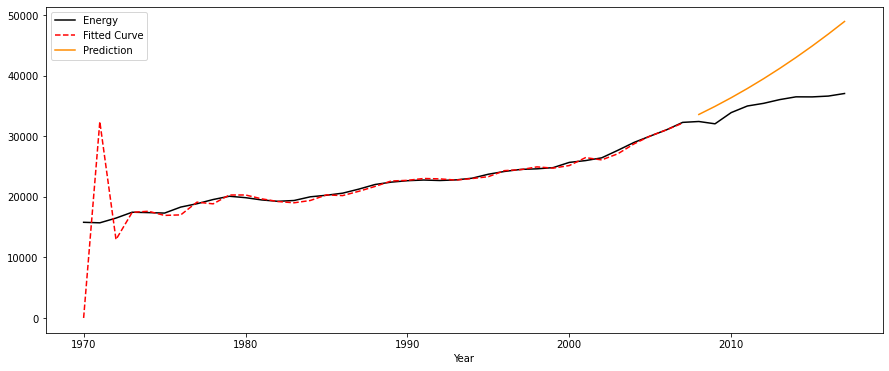

In [112]:
fig, ax = plt.subplots(figsize=(15,6))
df_yearly_sum.plot(ax=ax, color='black', label='Data')
fitted.fittedvalues.plot(ax=ax, color='red', linestyle='--', label='Fitted Curve')
y_pred.plot(ax=ax, color='darkorange', label='Prediction')
plt.legend()
plt.show()

/Users/constantinbogdanas/.pyenv/versions/3.8.10/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


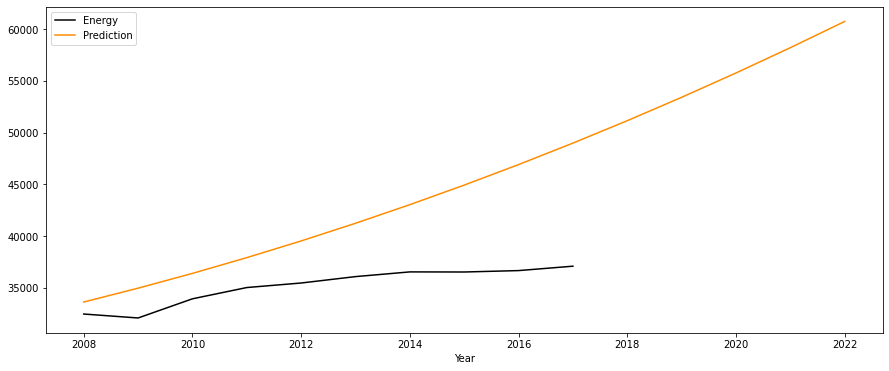

In [31]:
y_pred = fitted.forecast(len(X_test) +5 )
val = [i for i in range(2008,2023)]
y_pred.index = val
plot(X_test, y_pred)

In [64]:
win_length = 5
win_offset = 1
target_length = 1
def create_windows(data, win_length,win_offset,target_length):
    X = []
    y = []

    max_length = len(data) - win_length - target_length  + 1
    for i in range(0, max_length, win_offset):
        X.append(data[i:i+win_length])
        y.append(data[i+win_length:i+win_length+target_length])
    
    return np.array(X)[..., np.newaxis], np.array(y)

In [66]:

df_train, df_test = train_test_split(df_yearly_sum, test_size=0.2, shuffle=False)

X_train, y_train = create_windows(df_train, 
                                  win_length = win_length,
                                  win_offset = win_offset,
                                  target_length = target_length)

X_test, y_test = create_windows(df_test, 
                                win_length = win_length,
                                win_offset = win_offset,
                                target_length = target_length)

mu = X_train.mean()
si = X_train.std()

X_train_std = (X_train - mu)/si
y_train_std = (y_train - mu)/si

X_test_std = (X_test - mu)/si
y_test_std = (y_test - mu)/si

In [67]:
import tensorflow as tf
tf.keras.backend.clear_session()
tf.random.set_seed(42)

# Create a sequential model
model = tf.keras.models.Sequential()

# Add the input layer
model.add(tf.keras.layers.Input(shape=(win_length, 1)))

# Add the recurrent layer
model.add(tf.keras.layers.LSTM(units=30, return_sequences=True))
model.add(tf.keras.layers.LSTM(units=30, return_sequences=True))
model.add(tf.keras.layers.LSTM(units=30))


# Add the output layer
model.add(tf.keras.layers.Dense(units=target_length, activation=None))

# Print the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 30)             3840      
                                                                 
 lstm_1 (LSTM)               (None, 5, 30)             7320      
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trainable params: 0
_________________________________________________________________


In [68]:
# Choose the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

# Compile the model
model.compile(optimizer=optimizer,
              loss='mse')

In [69]:
early = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(X_train_std, y_train_std,
                    validation_split=0.1,
                    epochs = 25,
                    batch_size=32,
                    callbacks=[early])

Epoch 1/25
1/1 [==============================] - 7s 7s/step - loss: 0.6806 - val_loss: 6.9832
Epoch 2/25
1/1 [==============================] - 0s 42ms/step - loss: 0.6312 - val_loss: 6.5362
Epoch 3/25
1/1 [==============================] - 0s 53ms/step - loss: 0.5818 - val_loss: 6.0754
Epoch 4/25
1/1 [==============================] - 0s 48ms/step - loss: 0.5249 - val_loss: 5.5782
Epoch 5/25
1/1 [==============================] - 0s 55ms/step - loss: 0.4539 - val_loss: 5.0080
Epoch 6/25
1/1 [==============================] - 0s 54ms/step - loss: 0.3644 - val_loss: 4.3263
Epoch 7/25
1/1 [==============================] - 0s 92ms/step - loss: 0.2592 - val_loss: 3.5019
Epoch 8/25
1/1 [==============================] - 0s 48ms/step - loss: 0.1539 - val_loss: 2.5426
Epoch 9/25
1/1 [==============================] - 0s 46ms/step - loss: 0.0821 - val_loss: 1.5164
Epoch 10/25
1/1 [==============================] - 0s 44ms/step - loss: 0.0764 - val_loss: 0.7010
Epoch 11/25
1/1 [==============

In [103]:
df_test

,Energy
Year,
2008,32452.769572
2009,32071.208938
2010,33924.230435
2011,35013.384316
2012,35451.841075
2013,36070.476645
2014,36525.645526
2015,36515.871130
2016,36652.266661


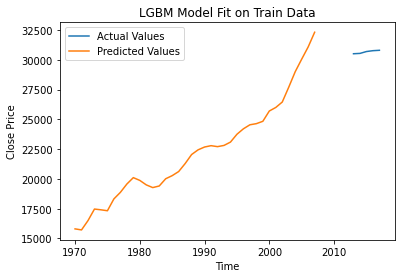

In [105]:
# Inverse the Standard Scaler transformation
indexes = [i for i in range(2013, 2018)]
inv_pred = (y_pred*si + mu).ravel()

# Create a Pandas Series to plot the results
inv = pd.DataFrame(inv_pred, 
          index= indexes, columns = ["Energy"])

# Plot the original data
# df_test.plot(figsize=(15,8), label='Original Data')
plt.plot(inv, label='Actual Values')
plt.plot(df_train, label='Predicted Values')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('LGBM Model Fit on Train Data')
plt.show()

Pas reussi a hyperparametrer a finir ce modele ((... 